In [11]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ForecastSimulator import Forecastsimulator, forecast_split
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from scikeras.wrappers import KerasRegressor
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.grid'] = True

In [12]:
today = date.today()
start_date = today - relativedelta(years=4)

print(start_date)
data = pd.DataFrame(web.DataReader('0RLS.UK', 'stooq', start_date))
data.info()

2019-01-07
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1030 entries, 2023-01-06 to 2019-01-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1030 non-null   float64
 1   High    1030 non-null   float64
 2   Low     1030 non-null   float64
 3   Close   1030 non-null   float64
 4   Volume  1020 non-null   float64
dtypes: float64(5)
memory usage: 48.3 KB


In [13]:
unicredit = data[['Close']]
unicredit = unicredit.sort_index(ascending = True)
unicredit

,Close
Date,
2019-01-07,9.77208
2019-01-08,9.77396
2019-01-09,9.76641
2019-01-10,9.85795
2019-01-11,9.94572
...,...
2023-01-02,13.46200
2023-01-03,13.81500
2023-01-04,14.35800


<AxesSubplot: xlabel='Date'>

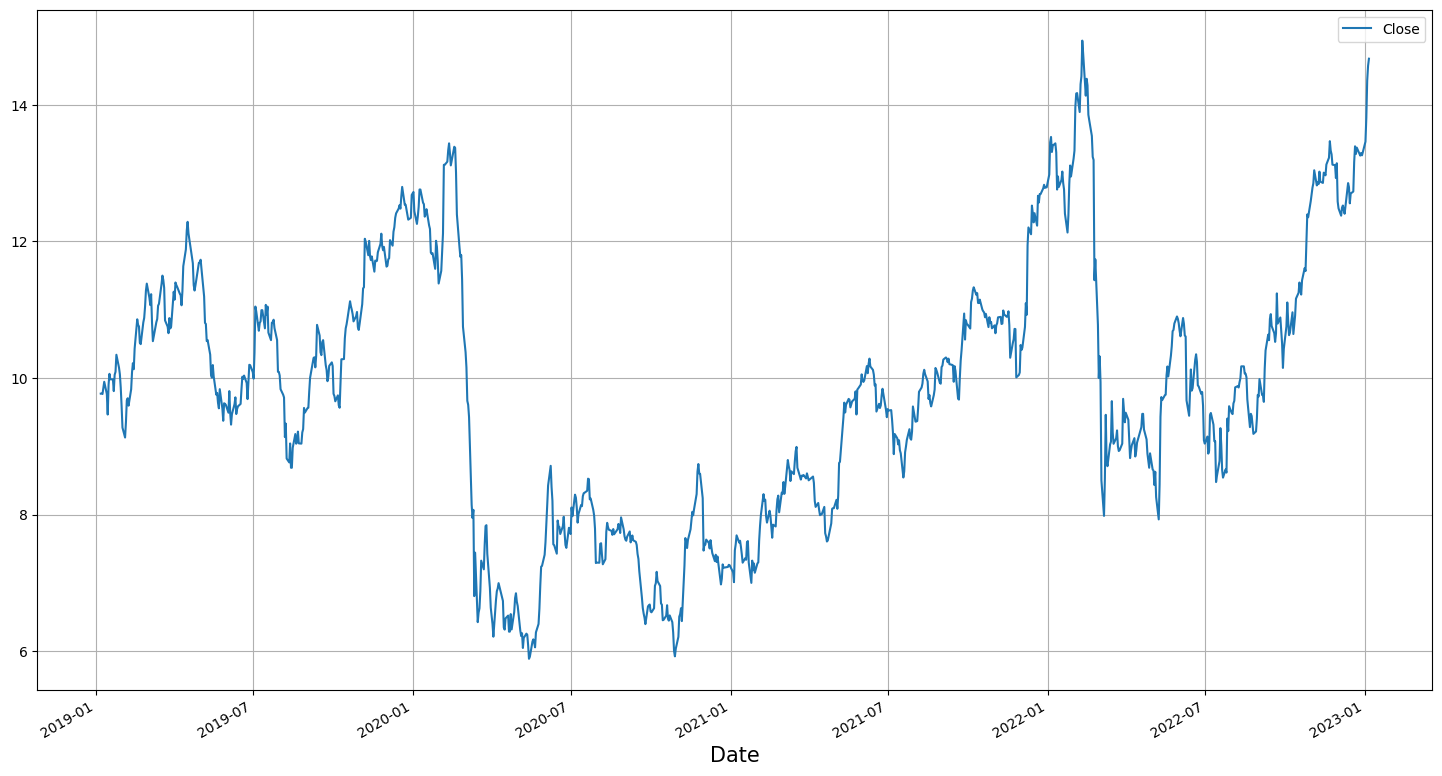

In [14]:
unicredit.plot()

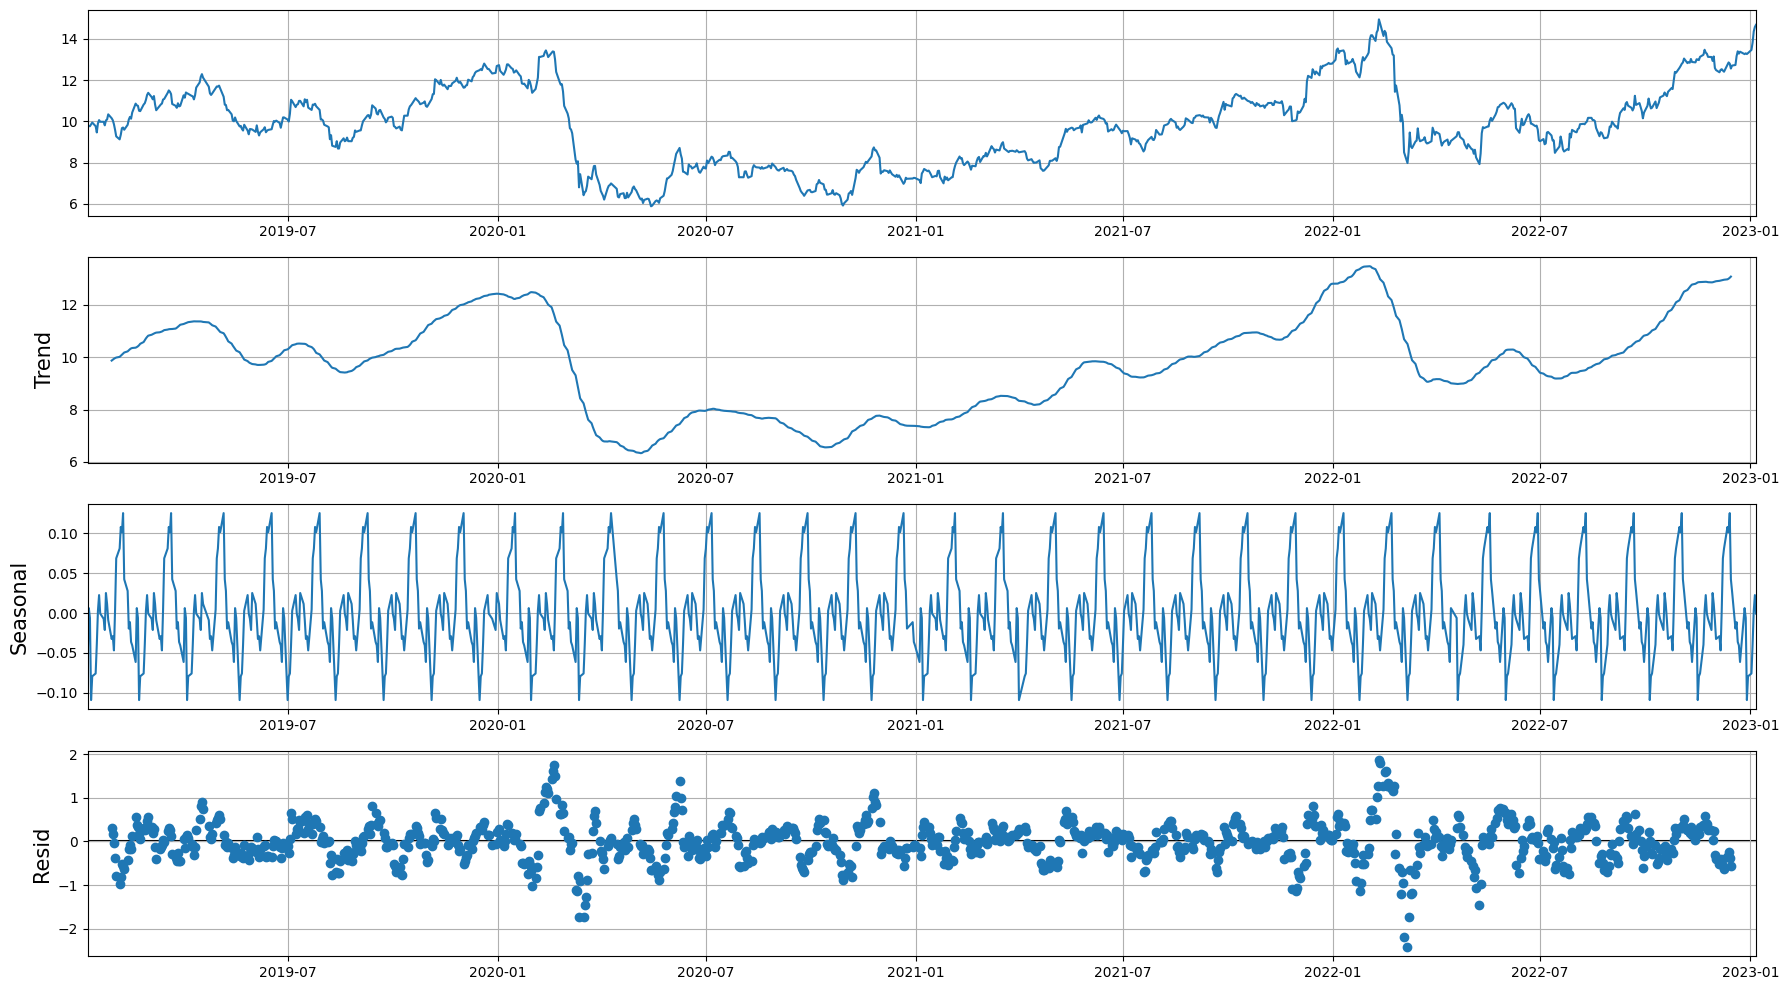

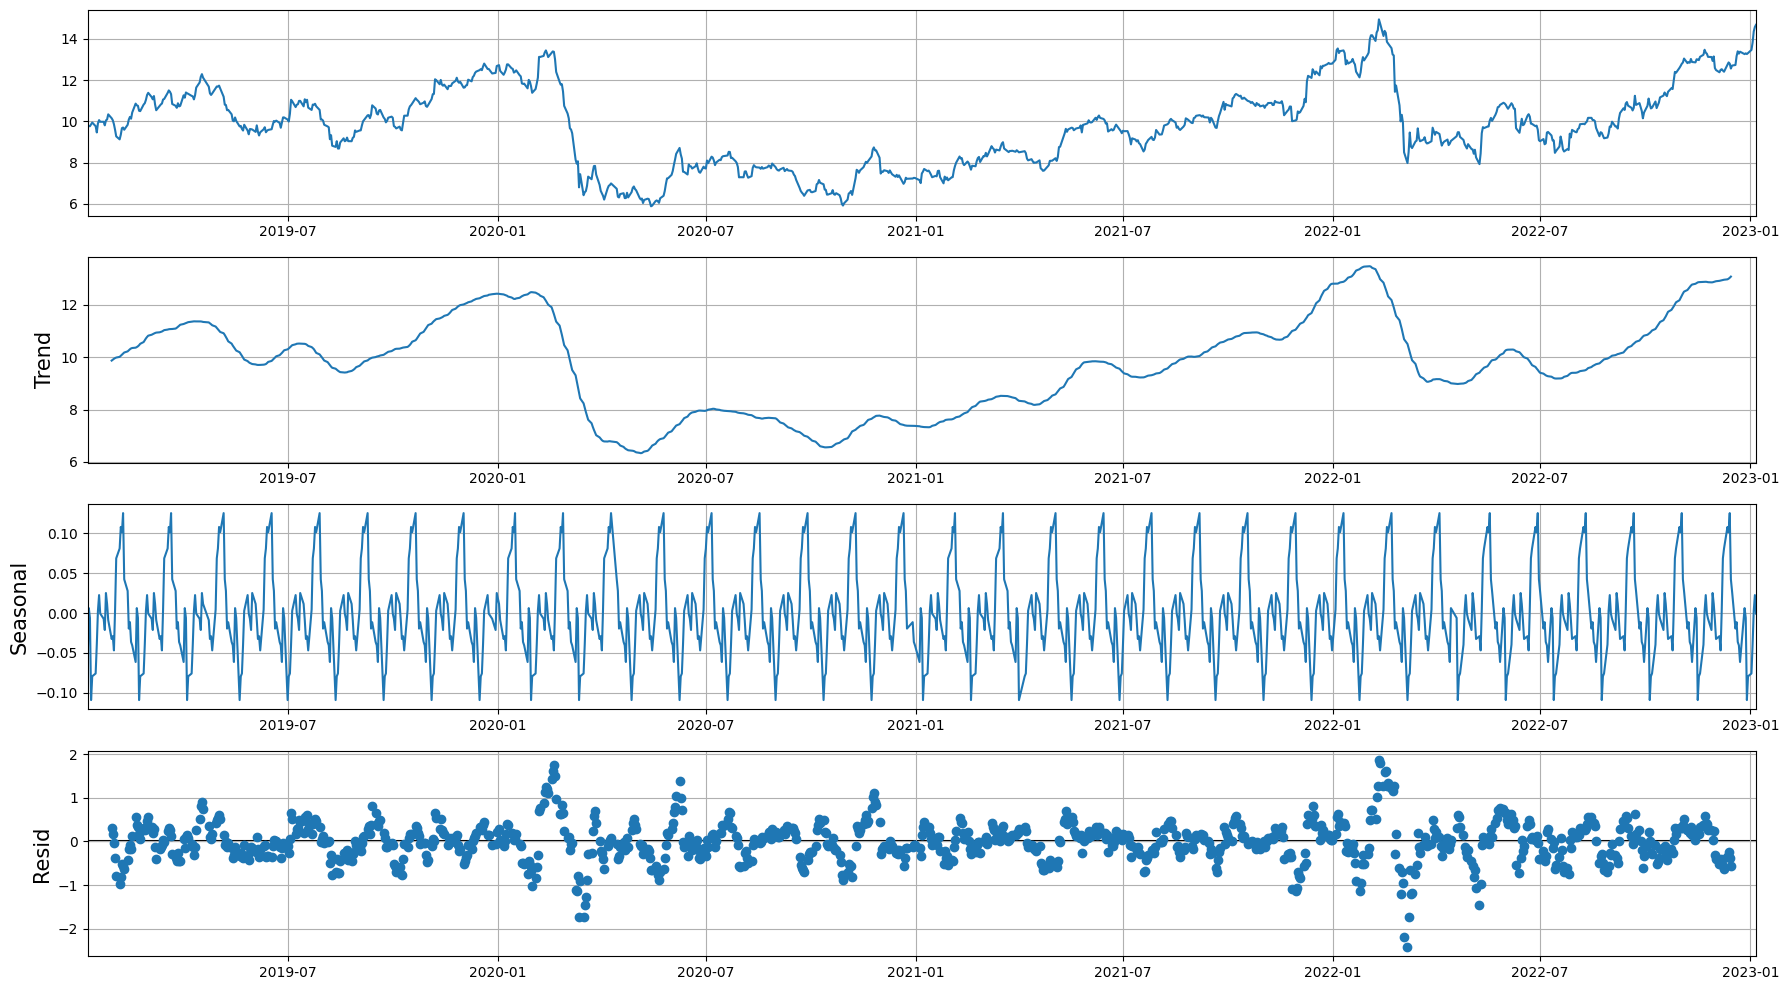

In [15]:
sd = seasonal_decompose(unicredit, period=30)
sd.plot()

Text(-2.5, 100, ' mean = -0.00356 \n median = 0.00723 \n std = 0.45967')

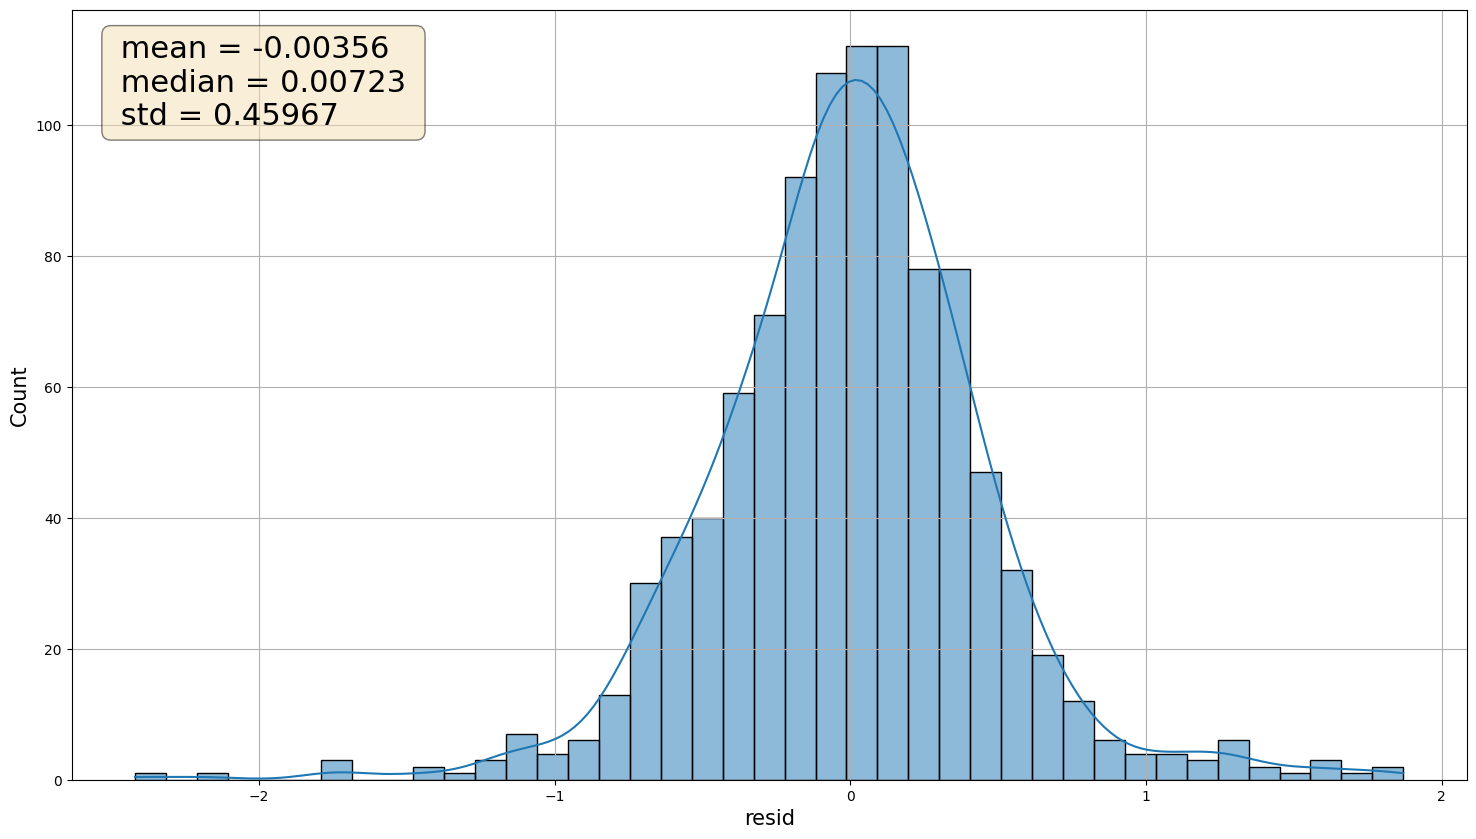

In [16]:
sns.histplot(sd.resid, kde=True)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

text = f' mean = {sd.resid.mean().round(5)} \n median = {sd.resid.median().round(5)} \n std = {sd.resid.std().round(5)}'
plt.text(-2.5, 100, text, fontsize = 22, 
         bbox=props)

In [17]:
def cnn_lstm(ws=30, dtp=1, multi=3):
    
    model = tf.keras.Sequential()

    # Creating the Neural Network model
    # CNN layers
    model.add(TimeDistributed(Conv1D(256, kernel_size=5, padding='same', activation='selu', input_shape=(None, ws, 1))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
#    model.add(Dense(5, kernel_regularizer=L1(0.01)))

    # LSTM layers
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=False)))
    model.add(Dropout(0.3))

    #Final layers
    model.add(Dense(dtp, activation='linear'))
    model.compile(optimizer='Adamax', loss='mae', metrics=['mse', 'mae', 'mape'])

    return model

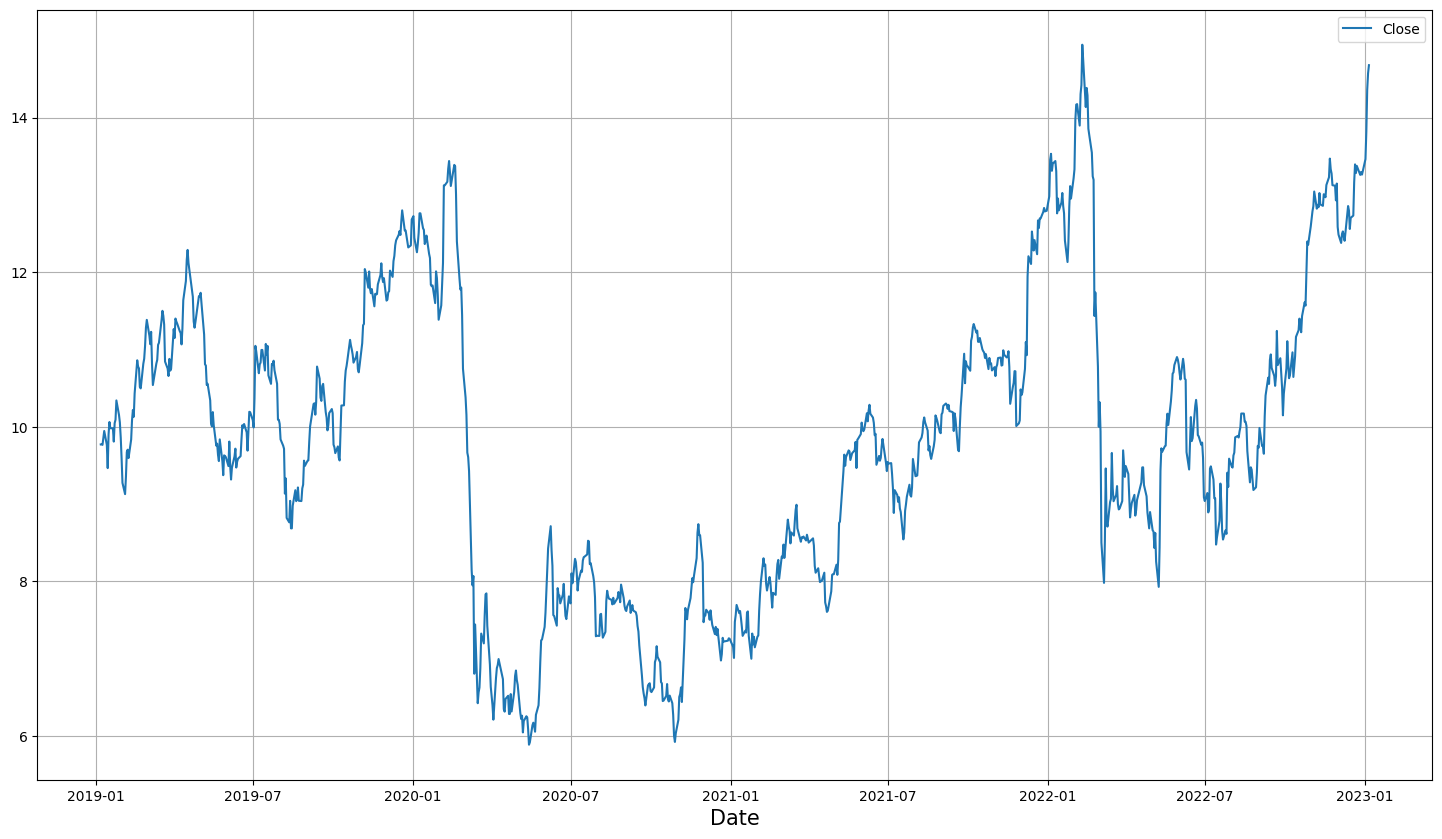

Epoch 1/50
17/17 - 12s - loss: 0.7678 - mse: 0.8783 - mae: 0.7678 - mape: 108.6381 - 12s/epoch - 693ms/step
Epoch 2/50
17/17 - 0s - loss: 0.4923 - mse: 0.4053 - mae: 0.4923 - mape: 244.1424 - 468ms/epoch - 28ms/step
Epoch 3/50
17/17 - 0s - loss: 0.3297 - mse: 0.1935 - mae: 0.3297 - mape: 221.5836 - 428ms/epoch - 25ms/step
Epoch 4/50
17/17 - 0s - loss: 0.2350 - mse: 0.1021 - mae: 0.2350 - mape: 113.1193 - 433ms/epoch - 25ms/step
Epoch 5/50
17/17 - 0s - loss: 0.2015 - mse: 0.0715 - mae: 0.2015 - mape: 85.4846 - 426ms/epoch - 25ms/step
Epoch 6/50
17/17 - 0s - loss: 0.1694 - mse: 0.0516 - mae: 0.1694 - mape: 69.9155 - 492ms/epoch - 29ms/step
Epoch 7/50
17/17 - 0s - loss: 0.1755 - mse: 0.0551 - mae: 0.1755 - mape: 52.7920 - 498ms/epoch - 29ms/step
Epoch 8/50
17/17 - 0s - loss: 0.1630 - mse: 0.0475 - mae: 0.1630 - mape: 59.7470 - 489ms/epoch - 29ms/step
Epoch 9/50
17/17 - 0s - loss: 0.1593 - mse: 0.0439 - mae: 0.1593 - mape: 51.6707 - 448ms/epoch - 26ms/step
Epoch 10/50
17/17 - 0s - loss: 0.

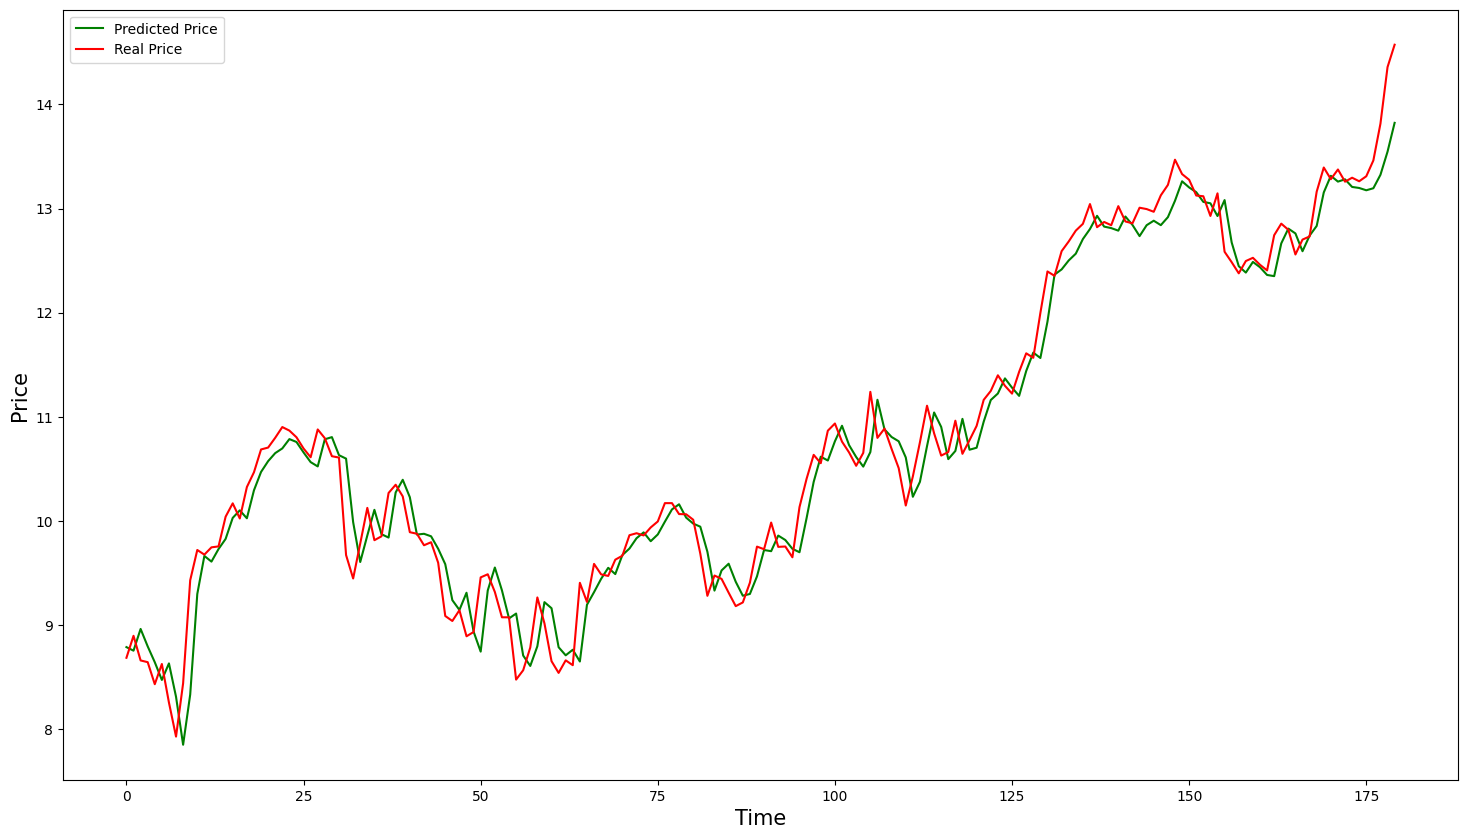

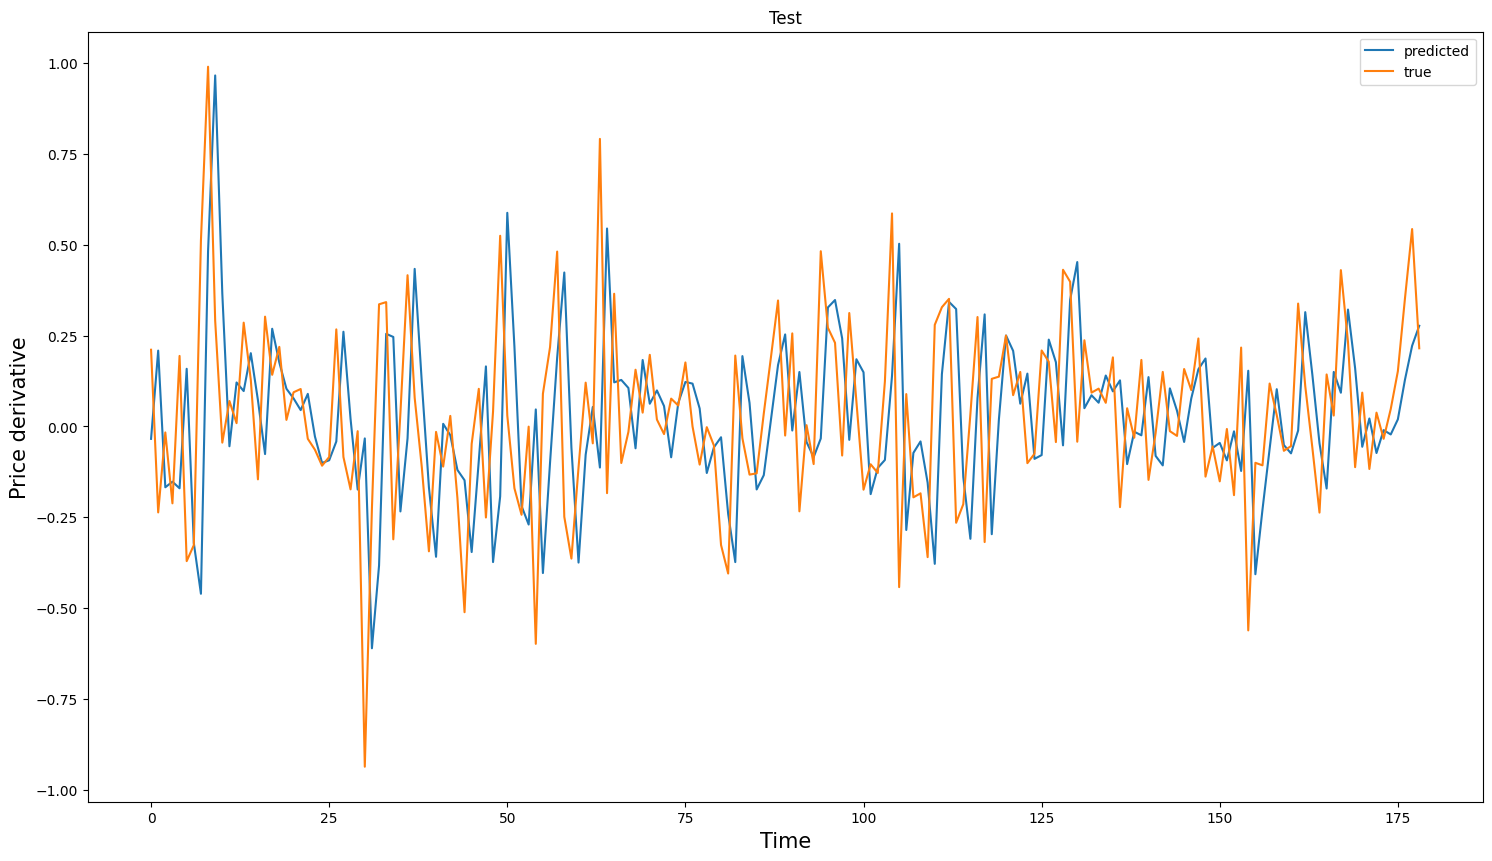

0.5280898876404494


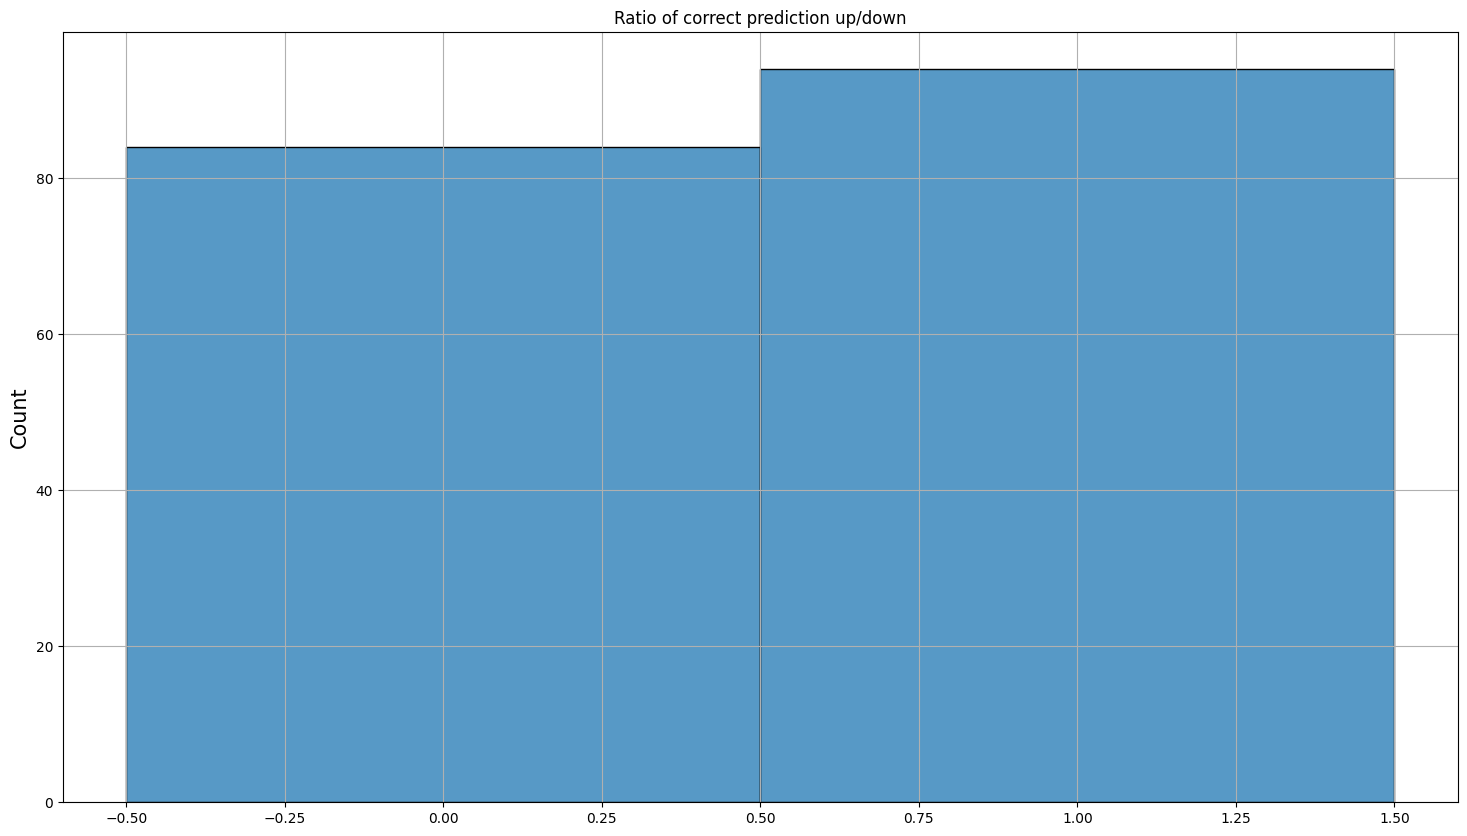

0.12094052850198148 2.5227381866612437


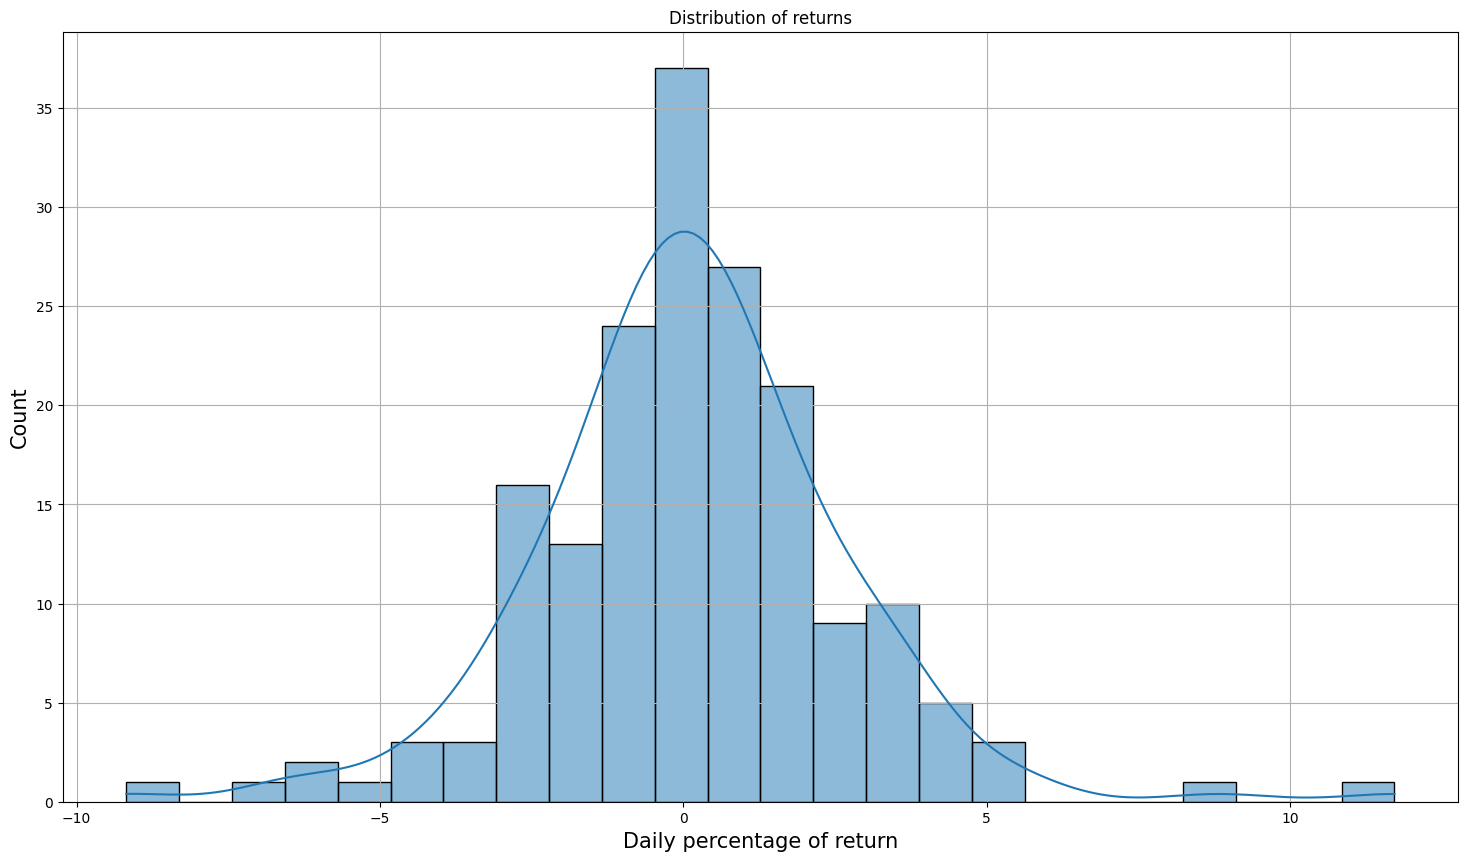

43.054828146705404


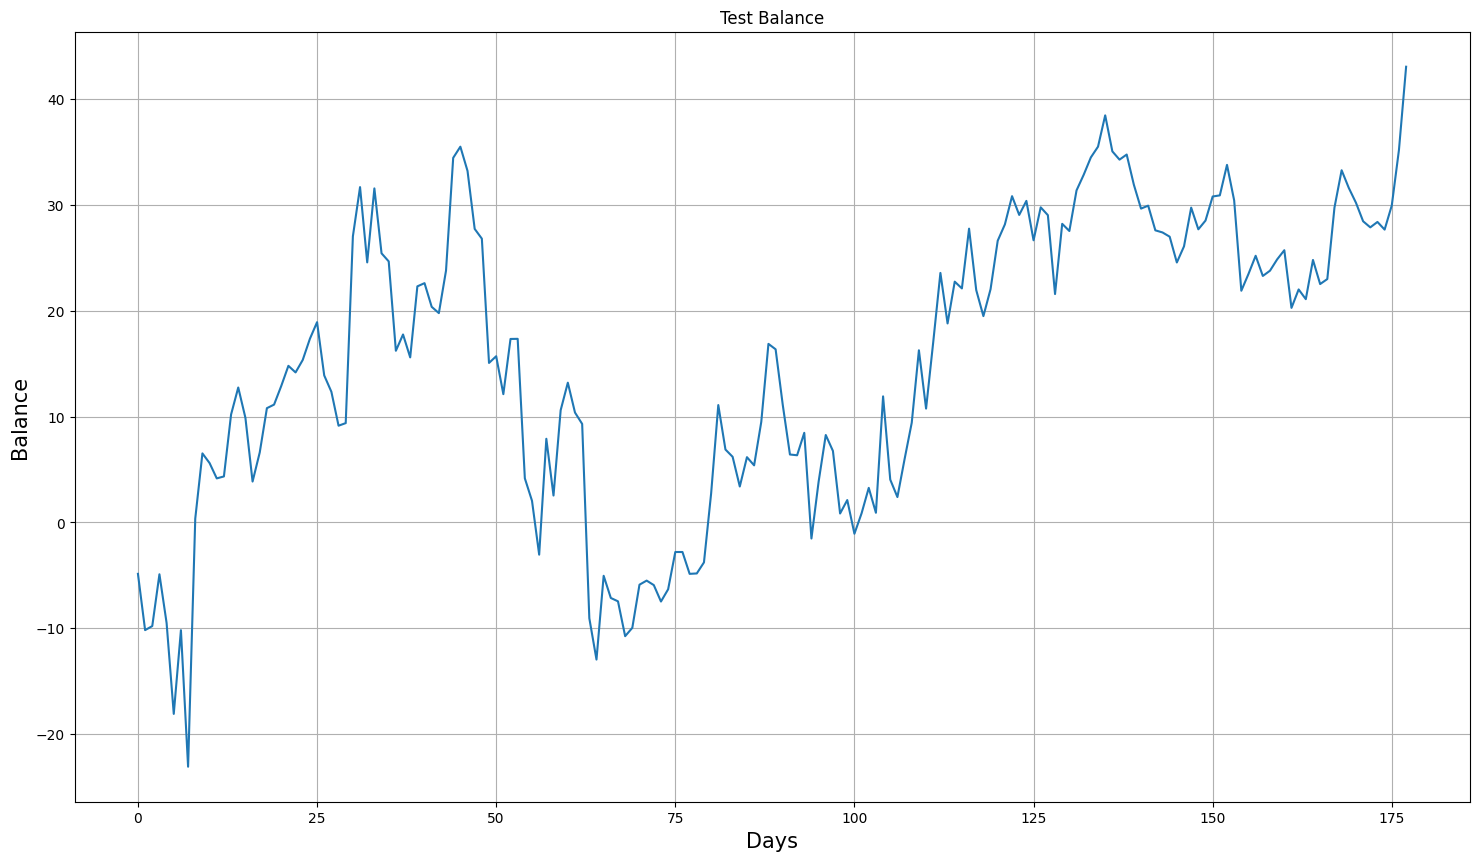

In [18]:
ws = 20
dtp = 1
sns.lineplot(unicredit)
plt.show()

X_train, X_test, y_train, y_test = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=180)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)
    
fs = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp, multi=3))
fs.train_nn(X_train_reshaped, y_train_scaled, epochs=50, batch_size=50)
prediction = scaler_y.inverse_transform(fs.predict(X_test_reshaped))

fs.plot_prediction(prediction, y_test)
fs.simulate(prediction, y_test)
del fs

Let's try to predict 5 days in a row and take the last one as prediction

Epoch 1/50
17/17 - 12s - loss: 0.7979 - mse: 0.9364 - mae: 0.7979 - mape: 104.4612 - 12s/epoch - 712ms/step
Epoch 2/50
17/17 - 1s - loss: 0.6109 - mse: 0.5992 - mae: 0.6109 - mape: 200.1177 - 587ms/epoch - 35ms/step
Epoch 3/50
17/17 - 1s - loss: 0.4382 - mse: 0.3345 - mae: 0.4382 - mape: 391.2188 - 551ms/epoch - 32ms/step
Epoch 4/50
17/17 - 1s - loss: 0.3525 - mse: 0.2300 - mae: 0.3525 - mape: 244.1760 - 607ms/epoch - 36ms/step
Epoch 5/50
17/17 - 1s - loss: 0.2861 - mse: 0.1537 - mae: 0.2861 - mape: 165.0715 - 545ms/epoch - 32ms/step
Epoch 6/50
17/17 - 1s - loss: 0.2409 - mse: 0.1068 - mae: 0.2409 - mape: 128.2164 - 549ms/epoch - 32ms/step
Epoch 7/50
17/17 - 1s - loss: 0.2228 - mse: 0.0925 - mae: 0.2228 - mape: 107.8187 - 546ms/epoch - 32ms/step
Epoch 8/50
17/17 - 1s - loss: 0.2205 - mse: 0.0888 - mae: 0.2205 - mape: 104.1022 - 677ms/epoch - 40ms/step
Epoch 9/50
17/17 - 1s - loss: 0.2120 - mse: 0.0822 - mae: 0.2120 - mape: 98.2353 - 555ms/epoch - 33ms/step
Epoch 10/50
17/17 - 1s - loss

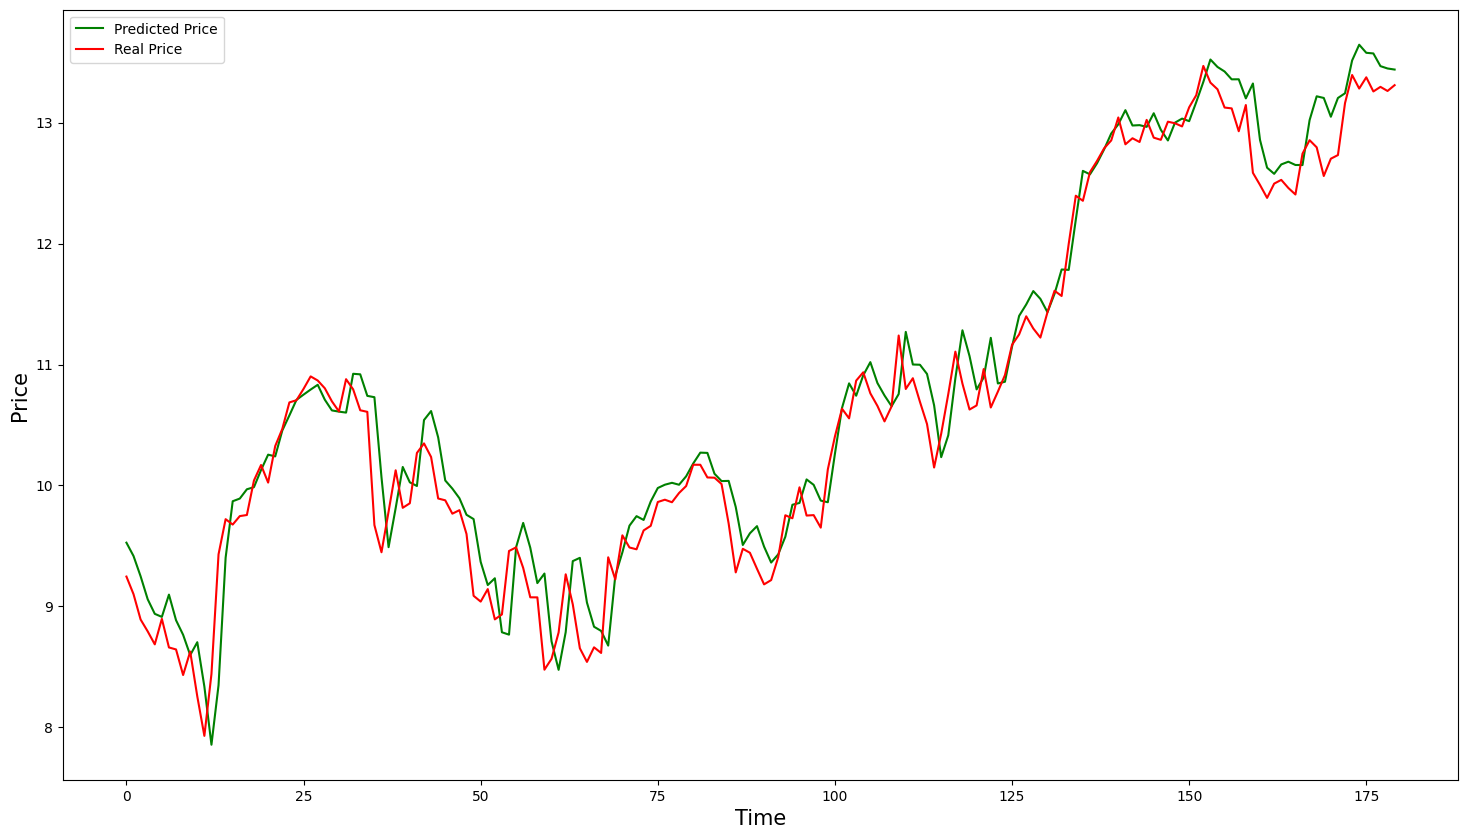

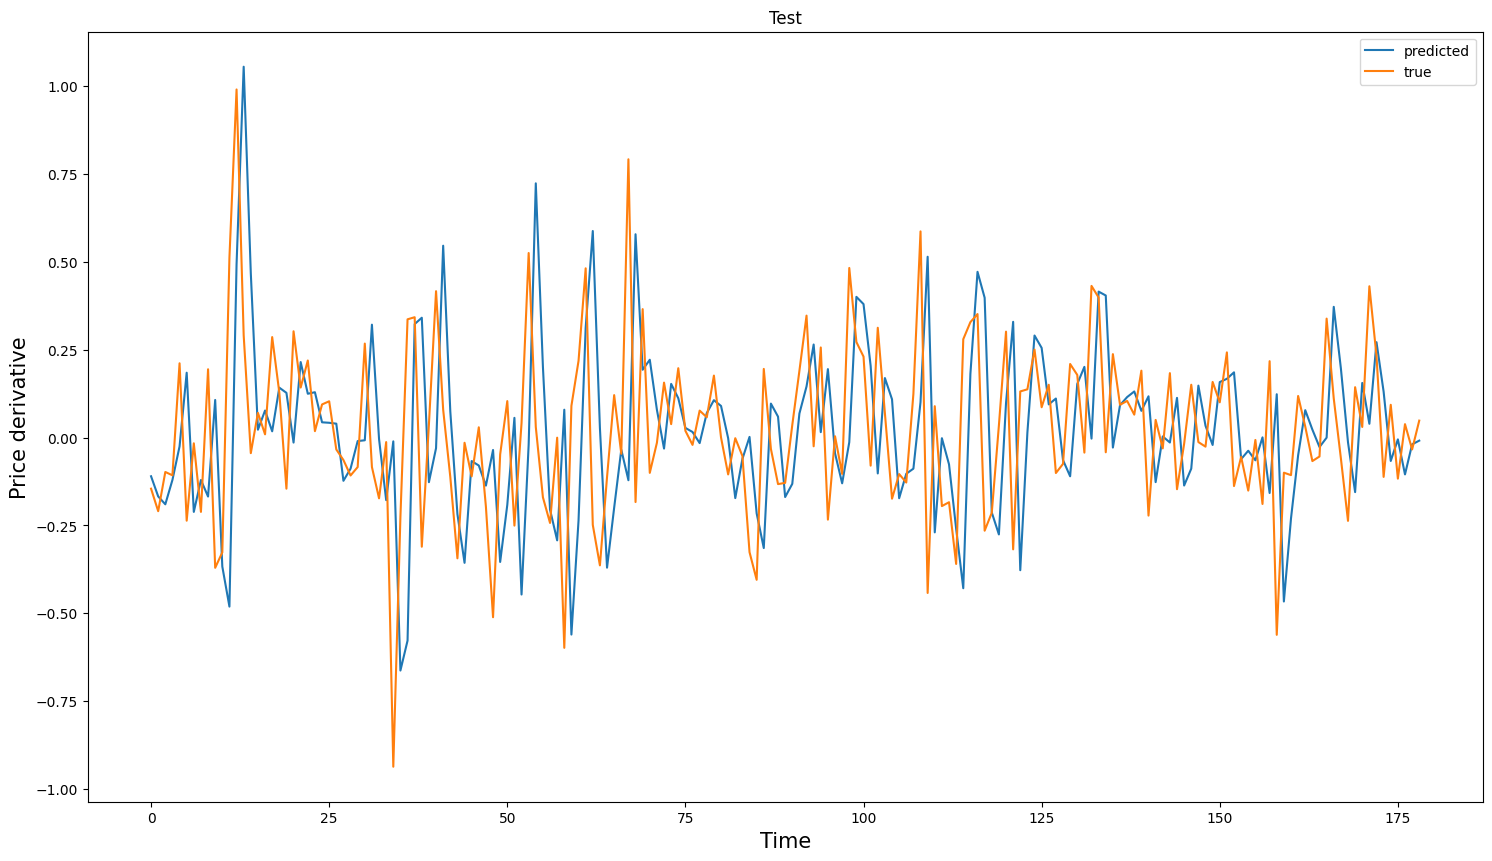

0.5393258426966292


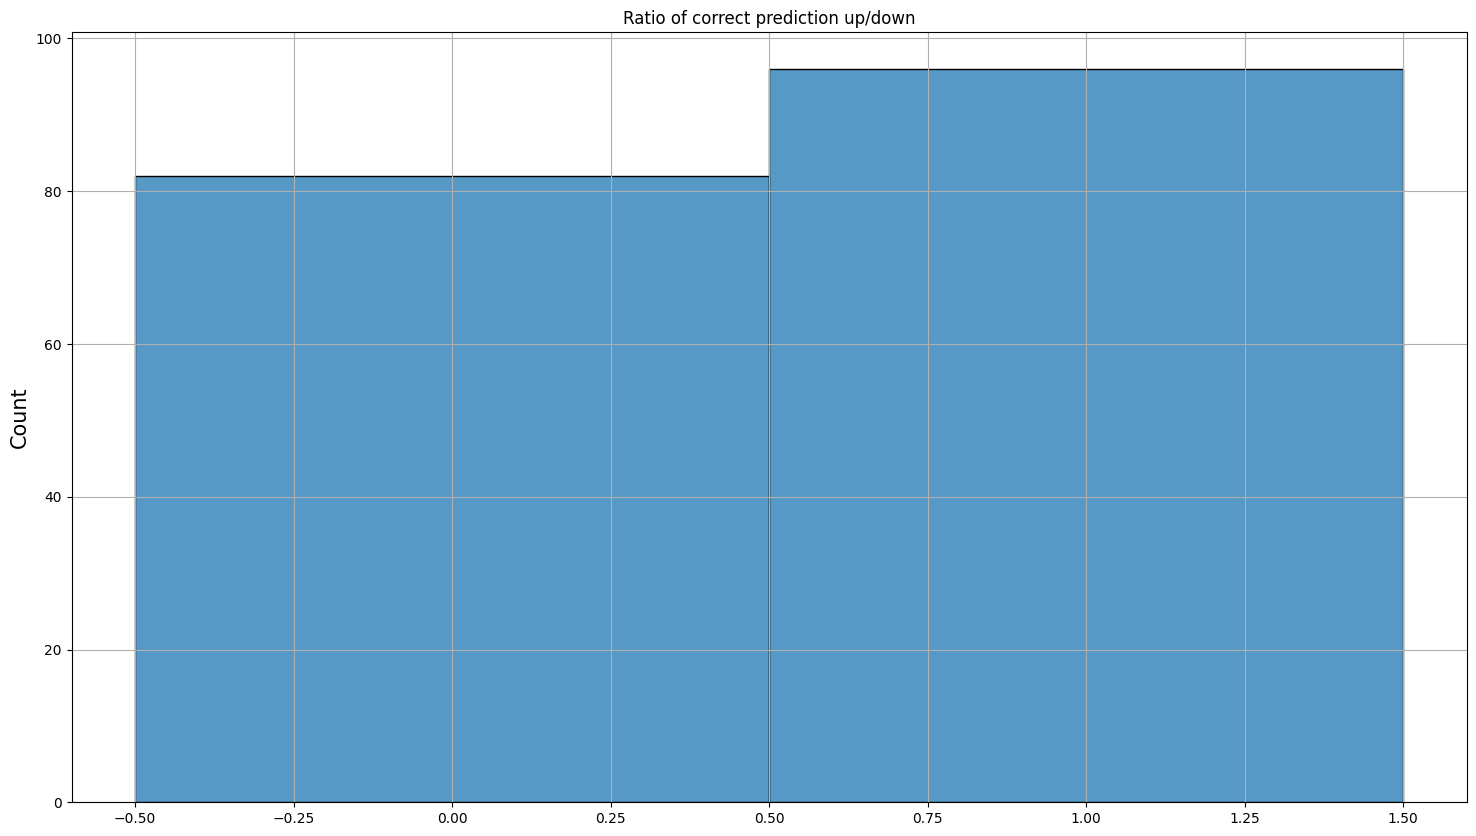

0.08196715421495918 2.5094874465075554


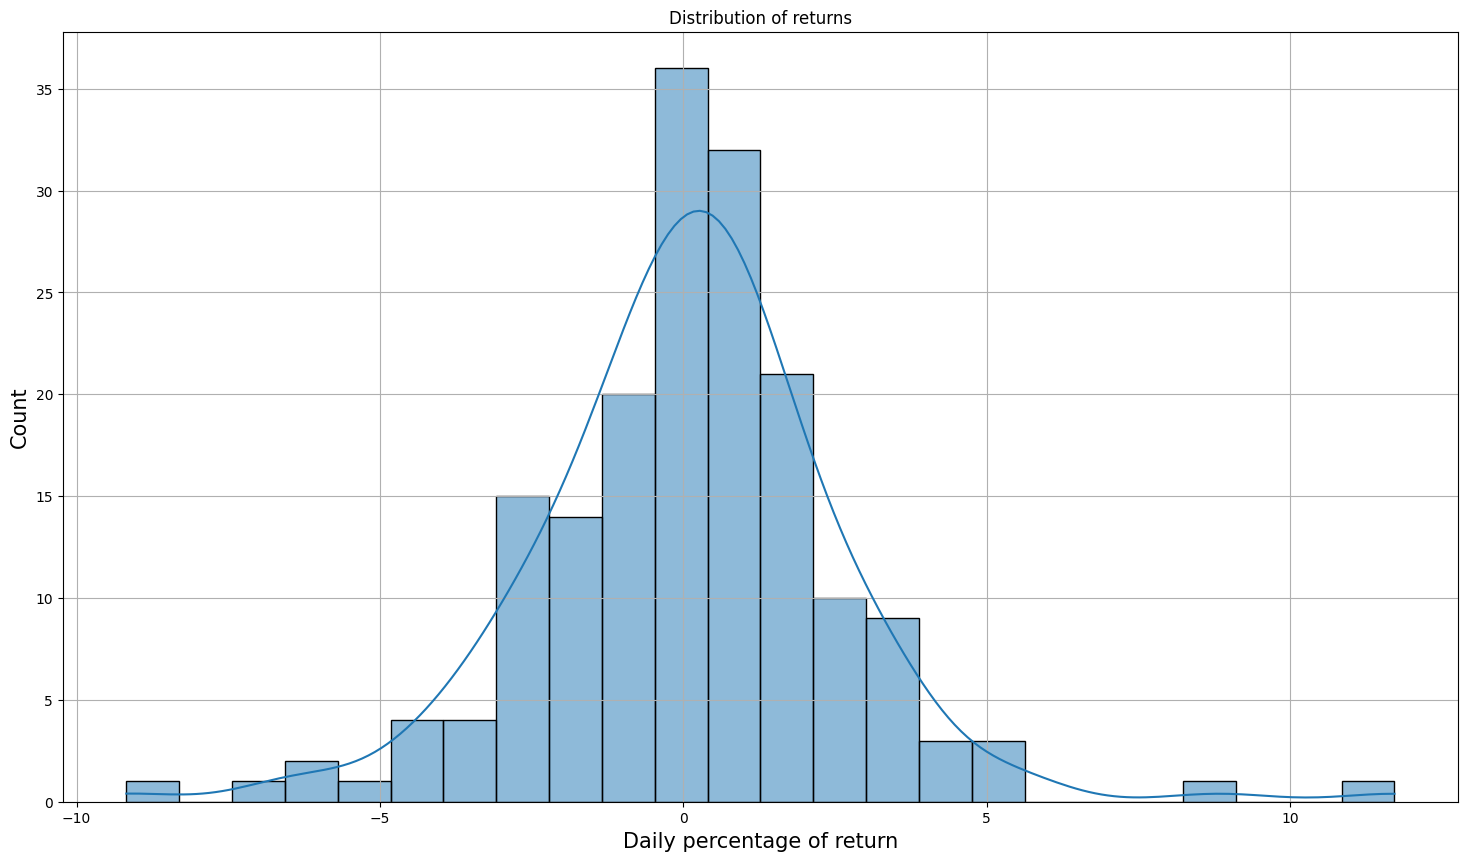

29.180306900525466


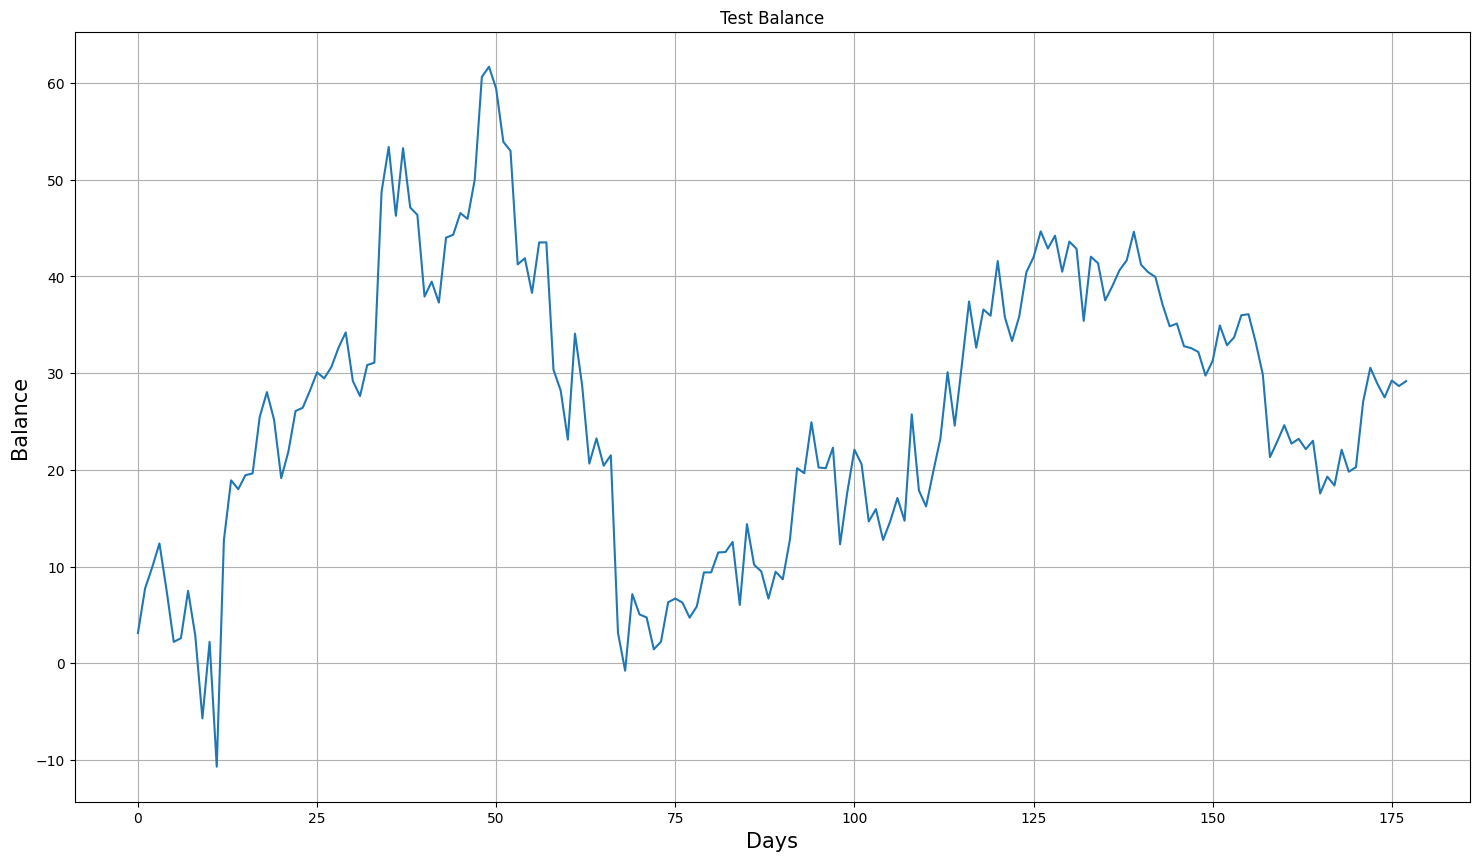

In [19]:
ws = 20
dtp = 5

X_train, X_test, y_train, y_test = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=180)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)
    
fs = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp, multi=3))
fs.train_nn(X_train_reshaped, y_train_scaled, epochs=50, batch_size=50)
prediction = scaler_y.inverse_transform(fs.predict(X_test_reshaped))

fs.plot_prediction(prediction, y_test)
fs.simulate(prediction, y_test)
del fs

This doesn't benefit the strategy of trading
<br>
Now let's try to retrain the model every 30 days and see if we can achieve better results

0
1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 22ms/step
3
1/1 [==============================] - 0s 22ms/step
4
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 22ms/step
6
1/1 [==============================] - 0s 21ms/step
7
1/1 [==============================] - 0s 24ms/step
8
1/1 [==============================] - 0s 21ms/step
9
1/1 [==============================] - 0s 22ms/step
10
1/1 [==============================] - 0s 21ms/step
11
1/1 [==============================] - 0s 21ms/step
12
1/1 [==============================] - 0s 23ms/step
13
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 22ms/step
15
1/1 [==============================] - 0s 24ms/step
16
1/1 [==============================] - 0s 19ms/step
17
1/1 [==============================] - 0s 21ms/step
18
1/1 [==============

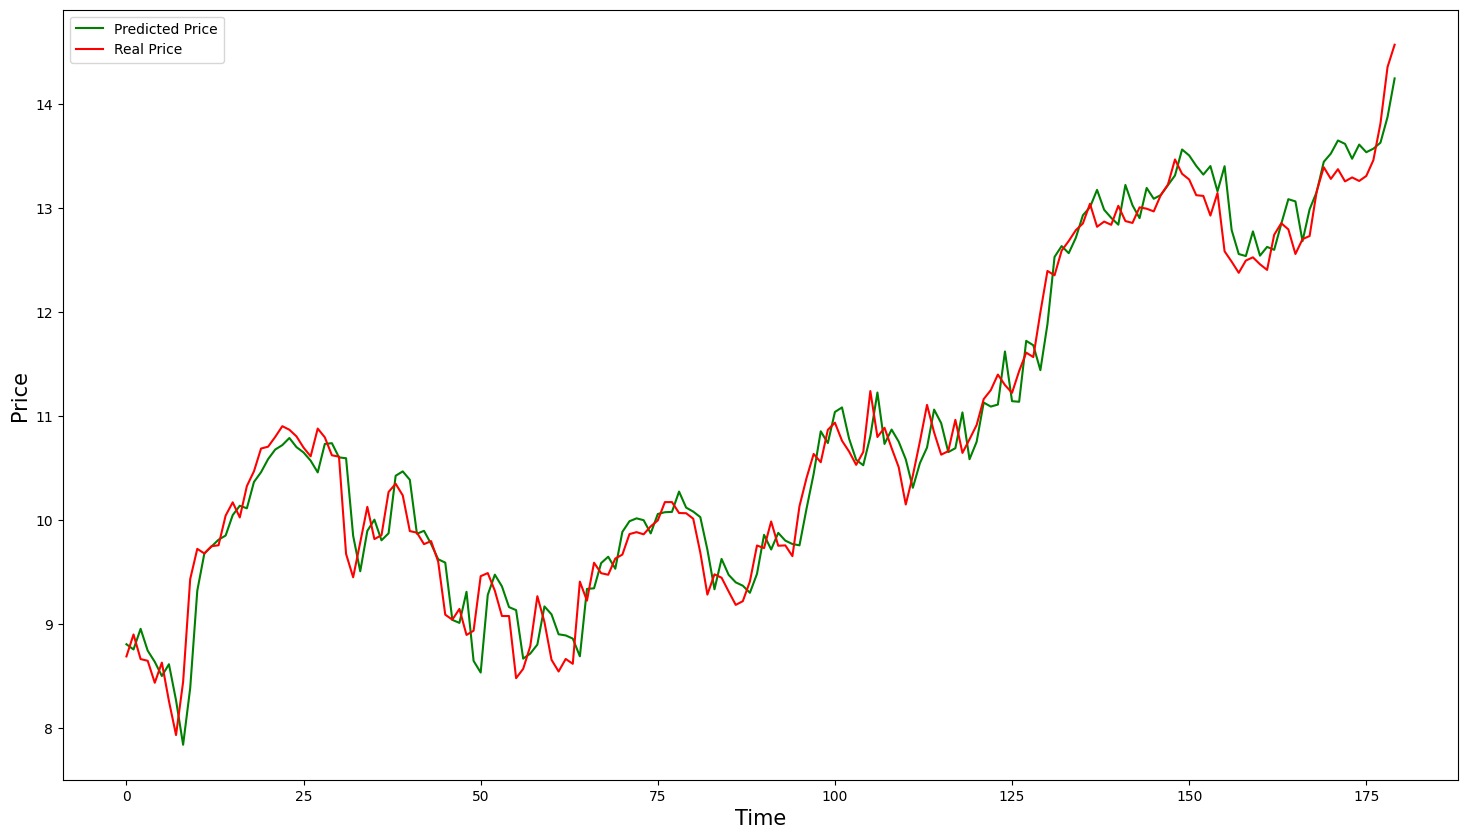

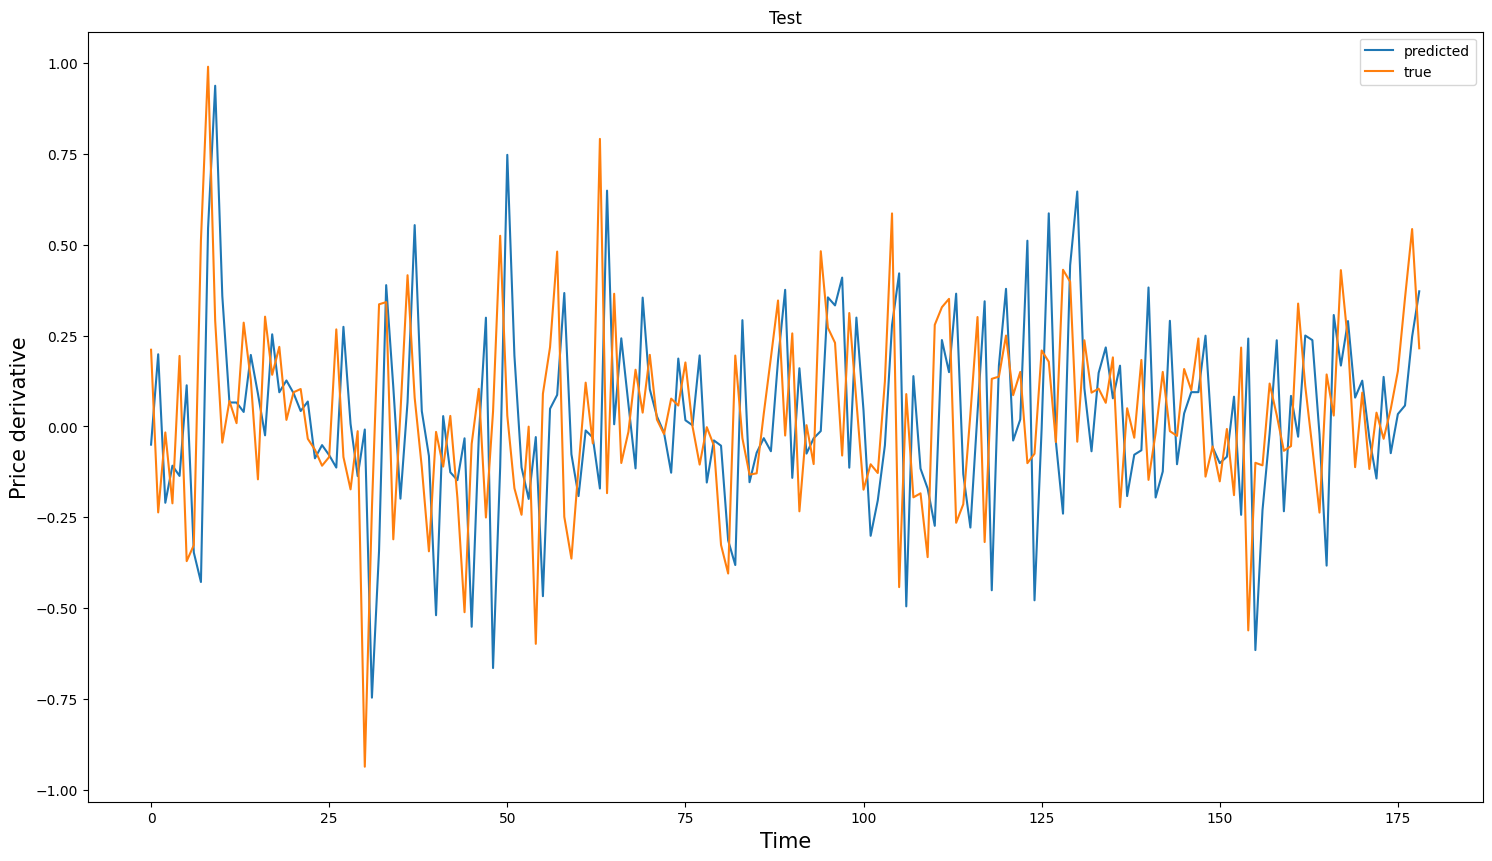

0.5561797752808989


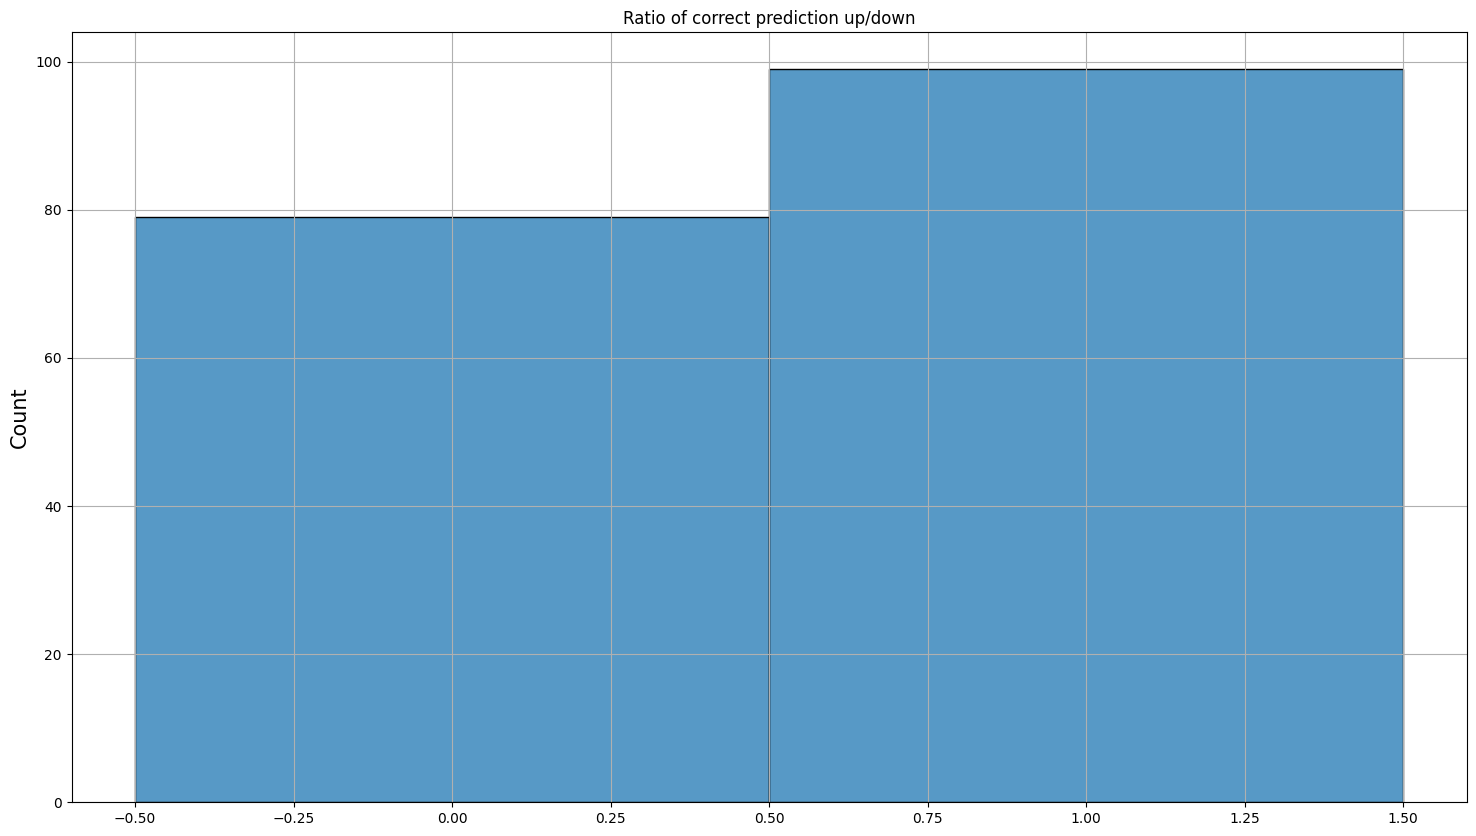

0.2570062234972897 2.512525098572522


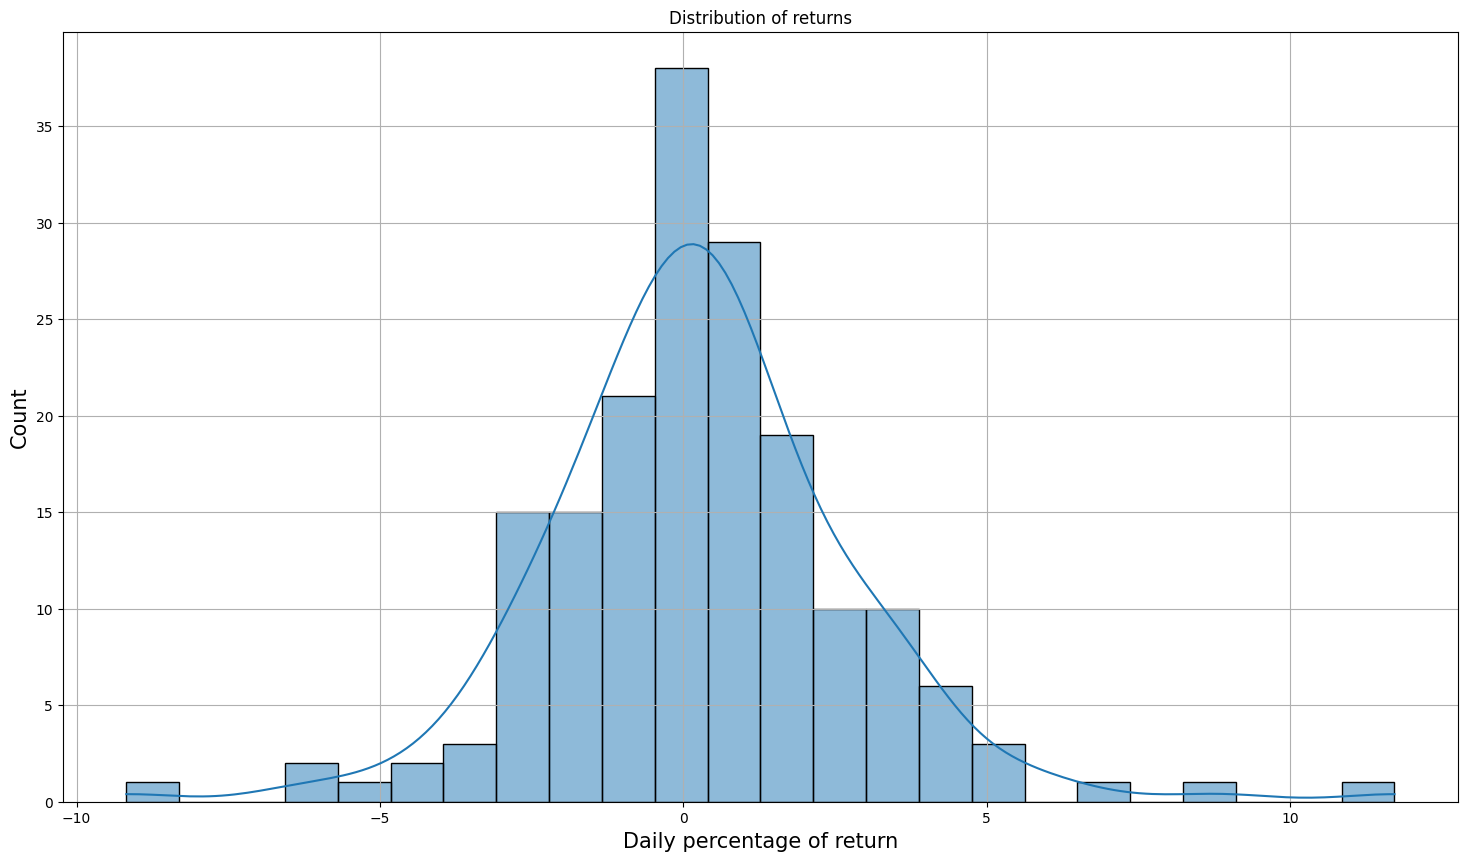

91.49421556503512


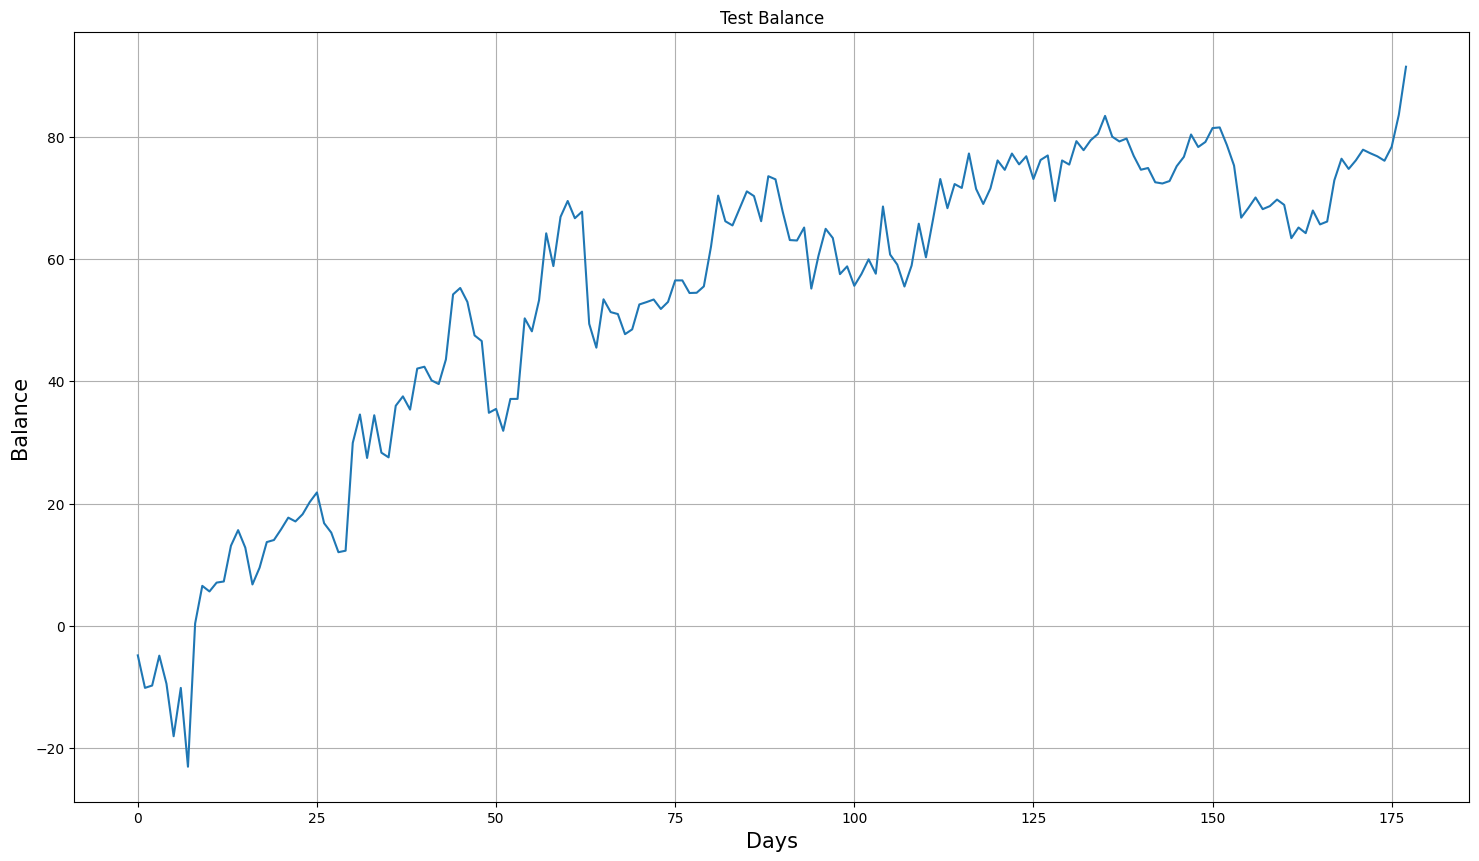

In [22]:
dtp=1

X_train, X_test, y_train, y_test = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=180)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)

fs2 = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp))
pred = fs2.retrain_nn(cnn_lstm(ws=ws, dtp=dtp), X_train_reshaped, X_test_reshaped, y_train_scaled, y_test_scaled, retrain_period=30)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_test)
fs2.simulate(prediction, y_test)

As we can see retrain the model every 30 days benefits the returns